# Compare Summary Tree with True Simulated Tree

In [1]:
from Bio import Nexus, Phylo, SeqIO
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pathlib import Path

from itertools import combinations

In [2]:
def get_branch_info(tree):
    """
    Return a list of (clade_id, branch_length, height, ci_lower, ci_upper).
    Height is distance from root to the clade.
    """
    branch_info = []
    i = 0
    for clade in tree.find_clades(order="preorder"):
        # Assign a clade ID (tip name or internal node ID)
        if clade.name:
            clade_id = clade.name
        else:
            clade_id = f"internal_{i}"
            i += 1

        # Branch length
        bl = clade.branch_length if clade.branch_length is not None else 0.0

        # Node height: distance from root
        height = tree.distance(tree.root, clade)

        # Confidence interval parsing
        lower_ci, upper_ci = None, None
        if clade.comment:
            match = re.search(r'length_range=\{([\d\.eE+-]+),([\d\.eE+-]+)\}', clade.comment)
            if match:
                lower_ci = float(match.group(1))
                upper_ci = float(match.group(2))

        branch_info.append((clade_id, bl, height, lower_ci, upper_ci))
    return branch_info


def get_pairwise_distances(tree):
    """
    Return dictionary of pairwise distances between all tips.
    """
    tips = [clade.name for clade in tree.get_terminals()]
    pairwise = {}
    for a, b in combinations(tips, 2):
        d = tree.distance(a, b)
        pairwise[(a, b)] = d
    return pairwise


def compare_tree_metrics(tree_sim, tree_constcoal):
    # --- Branch lengths and node heights ---
    sim_info = get_branch_info(tree_sim)
    const_info = get_branch_info(tree_constcoal)

    branch_length_df = pd.DataFrame({
        "branch": [b1[0] for b1 in sim_info],
        "length_sim": [b1[1] for b1 in sim_info],
        "length_constcoal": [b2[1] for b2 in const_info],
        "ci_lower_constcoal": [b2[3] for b2 in const_info],
        "ci_upper_constcoal": [b2[4] for b2 in const_info],
        "inside_ci": [
            b2[3] <= b1[1] <= b2[4] if b2[3] is not None and b2[4] is not None else None
            for b1, b2 in zip(sim_info, const_info)
        ],
        "height_sim": [b1[2] for b1 in sim_info],
        "height_constcoal": [b2[2] for b2 in const_info],
    })

    # Errors for branch lengths
    branch_length_df["length_diff"] = branch_length_df["length_constcoal"] - branch_length_df["length_sim"]
    branch_length_df["length_relative_error"] = branch_length_df["length_diff"] / branch_length_df["length_sim"]
    branch_length_df["length_abs_relative_error"] = np.abs(branch_length_df["length_relative_error"])

    # Errors for node heights
    branch_length_df["height_diff"] = branch_length_df["height_constcoal"] - branch_length_df["height_sim"]
    branch_length_df["height_relative_error"] = branch_length_df["height_diff"] / branch_length_df["height_sim"]
    branch_length_df["height_abs_relative_error"] = np.abs(branch_length_df["height_relative_error"])

    return branch_length_df

def compare_pairwise_distances(tree_sim, tree_constcoal):

    pd_sim = get_pairwise_distances(tree_sim)
    pd_const = get_pairwise_distances(tree_constcoal)

    pairwise_data = []
    for key in pd_sim:
        if key in pd_const:
            sim_d = pd_sim[key]
            const_d = pd_const[key]
            diff = const_d - sim_d
            rel_err = diff / sim_d if sim_d != 0 else np.nan
            pairwise_data.append({
                "tip_pair": f"{key[0]}-{key[1]}",
                "distance_sim": sim_d,
                "distance_constcoal": const_d,
                "difference": diff,
                "relative_error": rel_err,
                "abs_relative_error": np.abs(rel_err),
            })

    pairwise_df = pd.DataFrame(pairwise_data)

    return pairwise_df


In [3]:
def plot_tree_comparison(branch_length_df):

    # Drop rows with missing or non-positive values (log scale cannot handle <= 0)
    df_log = branch_length_df.dropna(subset=["ci_lower_constcoal", "ci_upper_constcoal"])
    df_log = df_log[(df_log["length_sim"] > 0) & (df_log["length_constcoal"] > 0)]

    # Compute asymmetric error bars for y-axis (const-coal tree)
    yerr_lower = df_log["length_constcoal"] - df_log["ci_lower_constcoal"]
    yerr_upper = df_log["ci_upper_constcoal"] - df_log["length_constcoal"]
    yerr = np.array([yerr_lower, yerr_upper])

    # Determine unified log-space limits
    log_min = df_log[["length_sim", "length_constcoal"]].min().min()
    log_max = df_log[["length_sim", "length_constcoal"]].max().max()
    margin = 0.1  # for padding
    log_min = log_min * (1 - margin)
    log_max = log_max * (1 + margin)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.errorbar(
    df_log["length_sim"],
    df_log["length_constcoal"],
    yerr=yerr,
    fmt='o',
    ecolor='gray',
    color='steelblue',
    markersize=4,
    elinewidth=0.6,
    capsize=3,
    alpha=1,
    label="Branch lengths"
    )

    # Add diagonal x = y line
    x_vals = np.logspace(np.log10(log_min), np.log10(log_max), 100)
    plt.plot(x_vals, x_vals, 'k--')

    # Set log scale
    plt.xscale("log")
    plt.yscale("log")

    # Set same limits and equal aspect ratio
    plt.xlim(log_min, log_max)
    plt.ylim(log_min, log_max)
    plt.gca().set_aspect('equal', adjustable='box')

    # Labels and formatting
    plt.xlabel("Branch length [years] (simulated tree, log scale)")
    plt.ylabel("Branch length [years] (const-coalescent tree, log scale)")
    plt.title("Log-Scaled Branch Length Comparison with Credible Intervals")
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.show()


# Extract 'model', 'growth_model', and 'mutsig' from tree_name
def extract_model_components(tree_name):
    model = "skyline" if "skyline" in tree_name else "constcoal"
    growth_model = "expgrowth_fast" if "expgrowth_fast" in tree_name else \
                   "expgrowth_slow" if "expgrowth_slow" in tree_name else "uniform"
    mutsig = "lowmutsig" if "lowmutsig" in tree_name else \
             "medmutsig" if "medmutsig" in tree_name else "highmutsig"
    return pd.Series([model, growth_model, mutsig])


def determine_sim_tree_path(row, sim_tree_mapping):
    for key, path in sim_tree_mapping.items():
        if key in row["tree_path"]:
            return str(path)
    return None

def extract_tree_index(tree_path):
    match = re.search(r"\.T(\d+)\.", tree_path)
    return int(match.group(1)) if match else None


In [4]:
def process_results(input_csv, mode = "branch"):
    """
    Use all successful runs from the paths csv file and compare branch lengths of simulated and constant-coalescent trees.
    Returns a DataFrame with the comparison results between simulated tree and trees reconstructed with BEAST.
    """

    df = pd.read_csv(input_csv)

    # Base repo path (local)
    repo_base = Path("/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses")

    # Adjust all paths to be relative to local repo and replace .trees with .tree
    df["tree_path"] = df["trees_path"].apply(
        lambda p: str((repo_base / Path(p).relative_to("/cluster/work/stadler/beckermar/BESP_paper-analyses")).with_suffix(".tree"))
    )
    df.reset_index(inplace=True)  # To track index for simulated tree matching

    # Path to simulated trees file
    sim_tree_base_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/results/pop_size_simulations/independent_homochronous"
    sim_tree_mapping = {
        "expgrowth_fast": f"{sim_tree_base_path}/expgrowth_fast/expgrowth_fast.trees",
        "expgrowth_slow": f"{sim_tree_base_path}/expgrowth_slow/expgrowth_slow.trees",
        "uniform": f"{sim_tree_base_path}/uniform/uniform.trees"
    }

    df["sim_tree_path"] = df.apply(determine_sim_tree_path, axis=1, args=(sim_tree_mapping,))
    df["sim_tree_index"] = df["tree_path"].apply(extract_tree_index)


    # Now process each row
    results = []
    for _, row in df.iterrows():
        tree_constcoal = Phylo.read(row["tree_path"], "nexus")
        sim_trees = list(Phylo.parse(row["sim_tree_path"], "newick"))
        tree_sim = sim_trees[row["sim_tree_index"]]

        if mode == "branch":
            eval_df = compare_tree_metrics(tree_sim, tree_constcoal)
        elif mode == "pairwise":
            eval_df = compare_pairwise_distances(tree_sim, tree_constcoal)
        else:
            raise ValueError(f"Unsupported mode: {mode}")
        eval_df["tree_name"] = Path(row["tree_path"]).stem
        results.append(eval_df)

    # Save combined output
    combined_df = pd.concat(results, ignore_index=True)

    combined_df[["model", "growth_model", "mutsig"]] = combined_df["tree_name"].apply(extract_model_components)

    return combined_df

def boxplot_branch_length_errors(df, metric = "length_abs_relative_error", title= "", logscale=True):

    # Define consistent hue order and colors
    hue_order = ["constcoal", "skyline"]
    palette = ["#a6444f", "#397398"]

    # Order of conditions: 3 growth models × 3 mutation signals
    mutsig_order = ["lowmutsig", "medmutsig", "highmutsig"]
    growth_model_order = ["uniform", "expgrowth_slow", "expgrowth_fast"]
    condition_order = [
        f"{g}/{m}" for g in growth_model_order for m in mutsig_order
    ]

    # Combine into condition column
    df["condition"] = df["growth_model"] + "/" + df["mutsig"]

    # Plot
    plt.figure(figsize=(14, 6))

    ax = sns.boxplot(
        data=df,
        x="condition",
        y=metric,
        hue="model",
        palette=palette,
        hue_order=hue_order,
        showfliers=False,
        order=condition_order,
    )

    sns.stripplot(
        data=df,
        x="condition",
        y=metric,
        hue="model",
        palette=palette,
        hue_order=hue_order,
        order=condition_order,
        dodge=True,
        alpha=0.2,
        size=2,
        jitter=True,
        linewidth=0
    )

    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[:len(hue_order)],
        labels[:len(hue_order)],
        title="Model",
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        frameon=False
    )

    # Log scale and styling
    if logscale:
        ax.set_yscale("log")
    else:
        ax.set_ylim(-5, 10)
    ax.set_ylabel(f"Absolute Relative Error (log scale, {metric})")
    ax.set_xlabel("")
    ax.set_xticks(range(len(condition_order)))
    ax.set_xticklabels(
        [cond.split("/")[1].replace("mutsig", "") for cond in condition_order], rotation=0
    )

    # Add growth model labels below
    for i, growth_model in enumerate(growth_model_order):
        mid = i * 3 + 1  # middle of 3 mutation signal blocks
        label = growth_model.replace("expgrowth_", "exp-growth ").capitalize()
        ax.text(mid, -0.08, label, ha='center', va='top', fontsize=10,
                transform=ax.get_xaxis_transform())

    # Tighten layout
    plt.title("Absolute Relative Branch Length Errors\nGrouped by Population Model and Mutation Signal")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0.03, 0.95, 1])  # make room for legend + bottom labels
    plt.show()

In [5]:
input_csv = "../scripts/successful_mcmc_runs.csv" 
branch_length_df = process_results(input_csv, mode="branch")


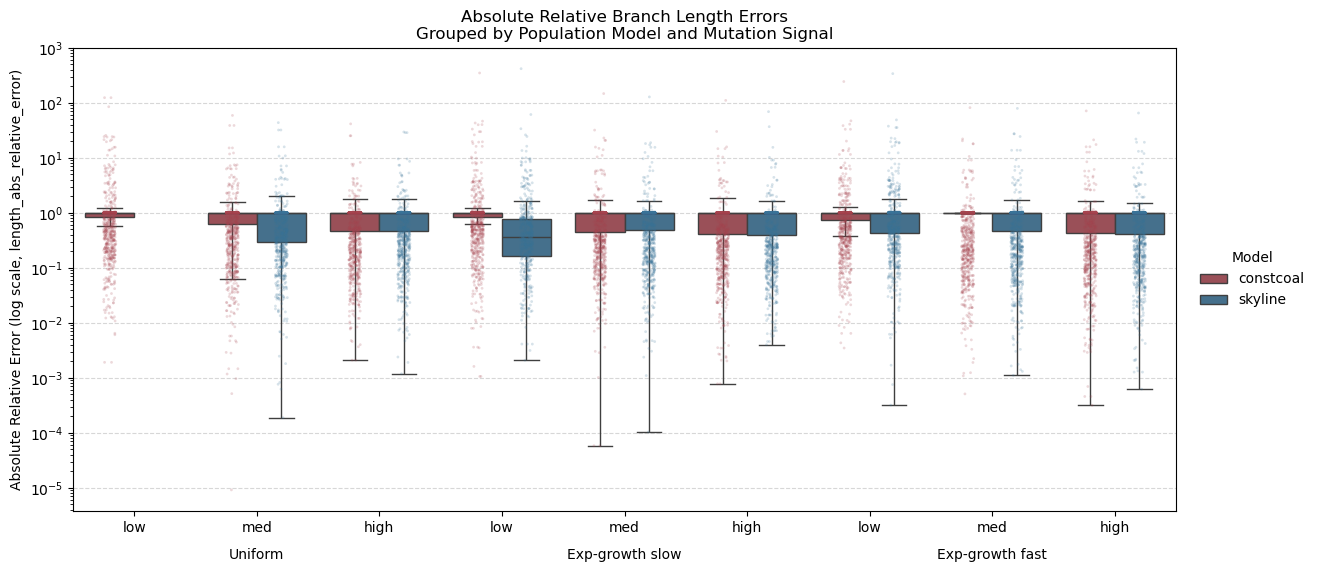

In [6]:
boxplot_branch_length_errors(branch_length_df, metric="length_abs_relative_error", title="Absolute Relative Branch Length Errors\nGrouped by Population Model and Mutation Signal")

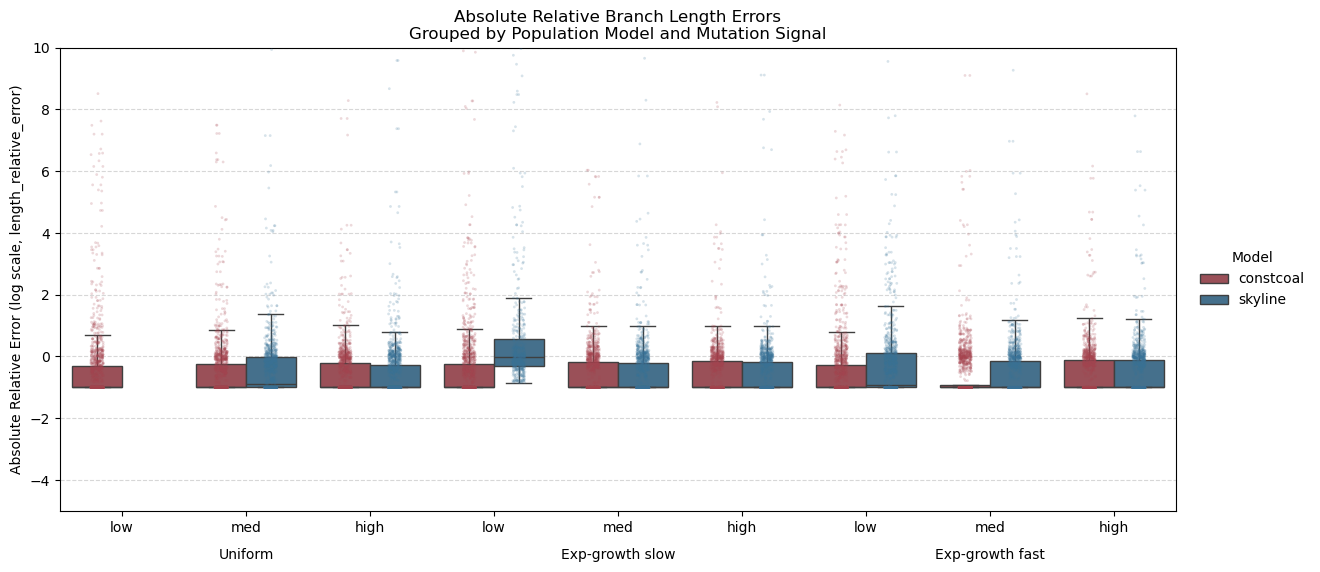

In [7]:
boxplot_branch_length_errors(branch_length_df, metric="length_relative_error", title="Absolute Relative Branch Length Errors\nGrouped by Population Model and Mutation Signal", logscale=False)

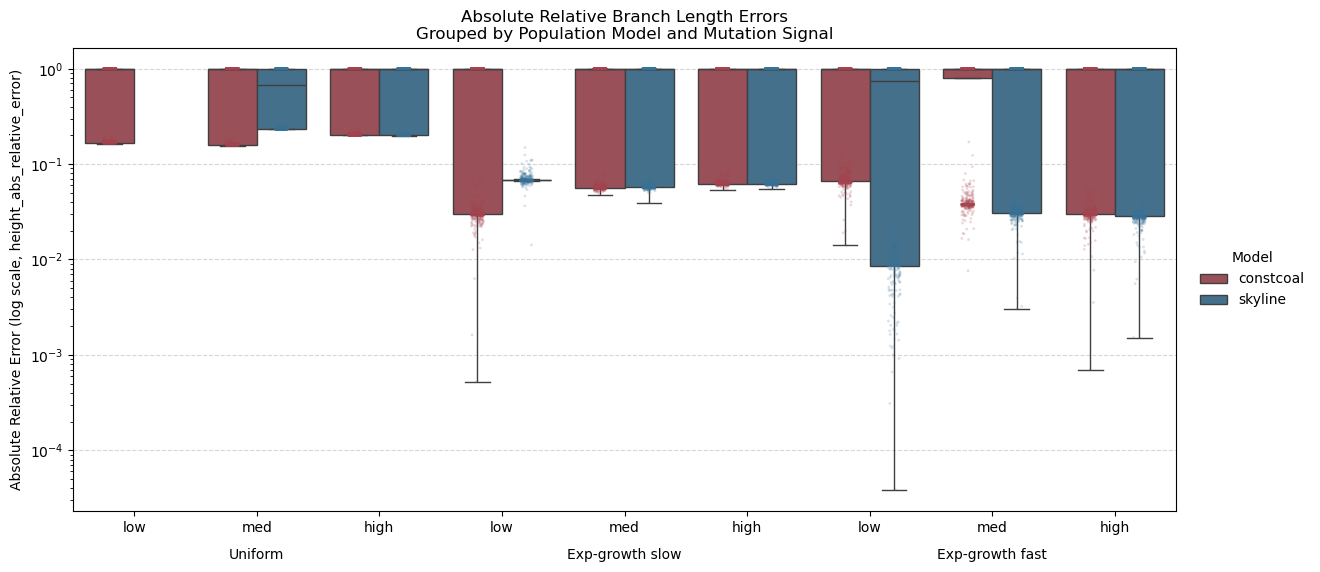

In [8]:
boxplot_branch_length_errors(branch_length_df, metric="height_abs_relative_error", title="Absolute Relative Node Height Errors\nGrouped by Population Model and Mutation Signal")

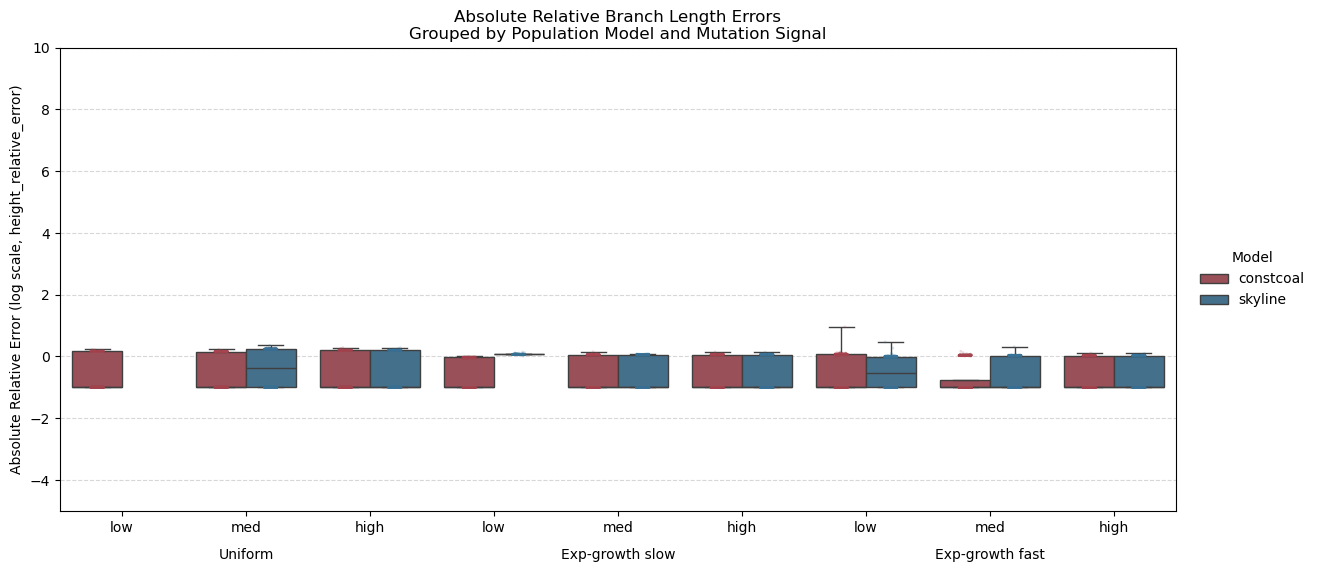

In [9]:
boxplot_branch_length_errors(branch_length_df, metric="height_relative_error", title="Relative Node Height Errors\nGrouped by Population Model and Mutation Signal", logscale=False)

In [10]:
treepath_sim = "../results/pop_size_simulations/independent_homochronous/uniform/uniform.trees"
tree_generator = Phylo.parse(treepath_sim, "newick")
#next(tree_generator)           # This skips the first tree
tree_sim = next(tree_generator)  # This gets the second tree

treepath_constcoal = "../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/uniform/lowmutsig/skyline_homochronous_uniform_lowmutsig.T0.tree"
tree_constcoal = next(Phylo.parse(treepath_constcoal, "nexus"))

FileNotFoundError: [Errno 2] No such file or directory: '../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/uniform/lowmutsig/skyline_homochronous_uniform_lowmutsig.T0.tree'

In [ ]:
total_length = sum(clade.branch_length for clade in tree_sim.find_clades() if clade.branch_length)
#total_length * 0.00045 * 450
total_length

17690.83420648728

In [ ]:
4.6 *4.5 * 0.01 * 30000

6210.0

In [ ]:
3.5 * 1.8 * 20000

126000.0

In [ ]:
1000000* 1e-5 * 30000

300000.0

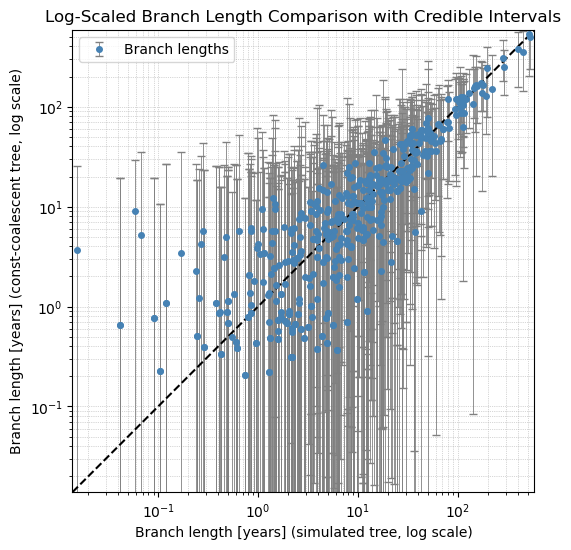

,branch,length_sim,length_constcoal,ci_lower_constcoal,ci_upper_constcoal,inside_ci,height_sim,height_constcoal,length_diff,length_relative_error,length_abs_relative_error,height_diff,height_relative_error,height_abs_relative_error
0,internal_0,0.000000,0.000000,NaN,NaN,None,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
1,internal_1,518.575584,529.999428,204.448585,795.457120,True,518.575584,529.999428,11.423844,0.022029,0.022029,11.423844,0.022029,0.022029
2,internal_2,113.635019,62.911079,1.809700,189.538337,True,632.210603,592.910507,-50.723940,-0.446376,0.446376,-39.300096,-0.062163,0.062163
3,internal_3,36.249445,29.204373,0.036003,116.622367,True,668.460048,622.114881,-7.045071,-0.194350,0.194350,-46.345167,-0.069331,0.069331
4,internal_4,26.513970,41.944581,0.847652,120.330594,True,694.974017,664.059461,15.430611,0.581980,0.581980,-30.914556,-0.044483,0.044483


In [ ]:
branch_length_df = compare_tree_metrics(tree_sim, tree_constcoal)
plot_tree_comparison(branch_length_df)
branch_length_df.head()

In [ ]:
print(f"Percentage of esitmates inside CI: {branch_length_df['inside_ci'].sum() / len(branch_length_df) * 100} %")

Percentage of esitmates inside CI: 99.74937343358395 %


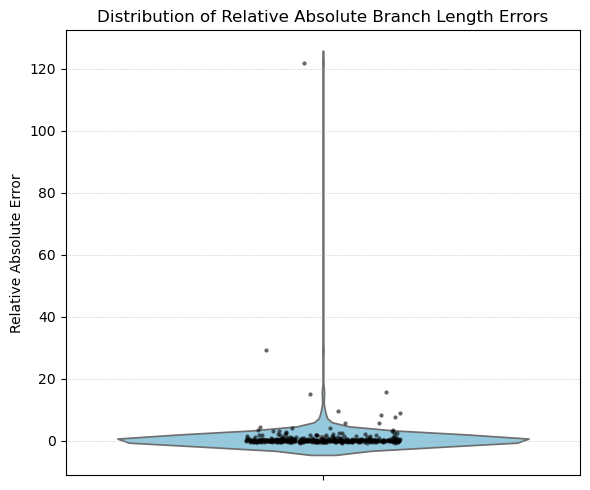

In [ ]:
# Drop any NaNs (e.g. from division by zero)
df_violin = branch_length_df.dropna(subset=['relative_error'])

# Plot violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(y=df_violin['relative_error'], inner="box", color="skyblue")

# Add individual points (with jitter)
sns.stripplot(
    y='relative_error',
    data=df_violin,
    color='black',
    size=3,
    alpha=0.6,
    jitter=0.15
)

plt.title("Distribution of Relative Absolute Branch Length Errors")
plt.ylabel("Relative Absolute Error")
plt.xlabel("")
plt.grid(True, axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

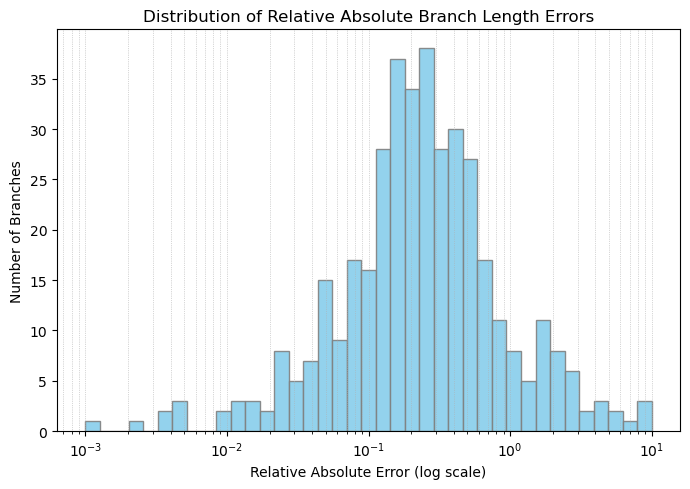

In [ ]:
# Plot histogram with log x-axis
plt.figure(figsize=(7, 5))
plt.hist(branch_length_df['abs_relative_error'], bins=np.logspace(-3, 1, 40), color='skyblue', edgecolor='gray', alpha=0.9)

plt.xscale('log')
plt.xlabel("Relative Absolute Error (log scale)")
plt.ylabel("Number of Branches")
plt.title("Distribution of Relative Absolute Branch Length Errors")
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# relative error
np.abs(branch_length_df['relative_error']).describe()

# Outliers steering error

count    398.000000
mean       1.010940
std        6.429095
min        0.000520
25%        0.121289
50%        0.231004
75%        0.489077
max      122.003045
Name: relative_error, dtype: float64

In [ ]:
np.abs(branch_length_df['difference']).describe()

count    399.000000
mean       6.048769
std       13.414403
min        0.000000
25%        1.296347
50%        3.032439
75%        6.266887
max      197.257228
Name: difference, dtype: float64

## Calculate average number of mutations

In [ ]:


# Path to your combined alignment
alignment_file = "../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/uniform/combined_alignments.fasta"

# Group sequences by tree ID (assuming headers like >T0_seq1, >T1_seq2, etc.)
tree_seqs = defaultdict(list)
for record in SeqIO.parse(alignment_file, "fasta"):
    tree_id = record.id.split("_")[0]  # Extract 'T0', 'T1', etc.
    tree_seqs[tree_id].append(record.seq)

def count_pairwise_mutations(seqs):
    """Returns list of all pairwise mutation counts between sequences in a tree."""
    n = len(seqs)
    mutation_counts = []
    for i in range(n):
        for j in range(i+1, n):
            diffs = sum(a != b for a, b in zip(seqs[i], seqs[j]) if a != '-' and b != '-')
            mutation_counts.append(diffs)
    return mutation_counts

# Store per-tree statistics
per_tree_stats = {}

all_mutation_counts = []

for tree_id, seqs in tree_seqs.items():
    mutations = count_pairwise_mutations(seqs)
    mean = np.mean(mutations) if mutations else 0
    std = np.std(mutations, ddof=1) if len(mutations) > 1 else 0
    per_tree_stats[tree_id] = {"mean": mean, "std": std}
    all_mutation_counts.extend(mutations)
    print(f"{tree_id}: mean = {mean:.2f}, std = {std:.2f}")

# Overall statistics
overall_mean = np.mean(all_mutation_counts)
overall_std = np.std(all_mutation_counts, ddof=1)

print(f"\nOverall average pairwise mutations per tree: {overall_mean:.2f}")
print(f"Overall standard deviation: {overall_std:.2f}")

FileNotFoundError: [Errno 2] No such file or directory: '../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/uniform/combined_alignments.fasta'

In [ ]:
count_pairwise_mutations(tree_seqs['T1']).summary()

NameError: name 'count_pairwise_mutations' is not defined

In [ ]:
len("TATATTACAGAATCAACAAACGTGTCTTGCAATGCTGGGCGCGAAGGCTATAAAGCCTACTTACCTGGCATACCCAAAAGCAAACAGCTTTCGTATTTAATTGATGCGTTGGTTCGTAACAGCAGTCCAAATAAATCGTCCAGAAGTAAGCTAGGAAGACAAGGCCAATTATCTAAAGGTCCTAACAATGAACGGGGCTGGTTGCCTTGAGCGCTGTTTATCAAAATGCAATGCGTCCCTGTTCATGCTATGTAAGTAAGTCAAACAAAAATATGCGTCGCGTTGAACACCAAGTGACTCGATAGACGACAGCCGGCCTGGTTCGGTCCTGAAGTGCAACCCAACGCCGATCTTTACACACGCTCAGAGCTCGTGATTGTATCTCTTGGGACGTAGCGAGGAATTACTCGGCAGTGTCTTCTTAAACGTCTGGCATTCATTGCCTTCCTGCCGTTTCCAGAATATTTCCTATCTGATCAGTATCCCGCTAGCGTGGATGCGCTCTTCCTTCATCCTAAGCCAAGCAGGCAGCTGCGGTATAACAAGTTATAGCGAGCCGGTGCTAGCCCCGAGCAATGTCGGCTGTTGATTAAAAGGTTATCCGTGTAGAGATATGGTTTTACAACAAAATCTGCCTTTAGGCCTACCTACACGATTTGTCATGGGTGATAGTCCAGTAGAAAATCCTGGCCGGGCCATGTGCCCCGTTAGGATCAACGTAGCCCATATTAGTTTTGTCTTCTATCTGGTAAGATCCGTCCCACTTTAATCGTGATCACGAAGAGTTTGCATCGGACCCGATCACATGATGCTTGGGCTGCTTGTATAGTTTGCCACAACCGAAATTAGAGGTCTAAACCTGTTTTGCATGCAAATTATACGTTTACTACAGGTTGTCGTTGGCTCTCGCGTCTACAGTCGGATGTGATATCGTCCCATTGCCGTTGACGTACGTAGGAAGAGGGCGAACAGGTCGCTTCTTGGCAGGCAATGTATTTCTGAGTCTTACATTGTTGTCTCTCCAATTTAATCGTCCTACGAGCTGTGTTTTCGTGAAGGAACGAGTTCGAGTACCACAATGCAGCACTTTTCTTCAGACTAGCTGGGTCCTCAACTATAGCGCTAACTGTCATTGCTATACGCTCTTTTCCAGGTTCCTGCCAACCCCTCCAGATACTCGTTTCGAATGTTCATTAGGTAATGCACCCCTTCTGCTAAATTGGGTCAGACGTCGTACTCATTGGACACTGCCTAGCTGCTAGTATGGATAACTAATCACTGGTCGGCTACATAAGGTAATATTGGCTATACTTCTAATCCGCCAGGTGGTTCCCGCGTGAGACTTTTTCCTGTCAAGTTCCCAACCCCAAAGGGCAGATCTTTACACCCTGTACTCAGTCGATGAATGGACTCAGTTTGAGACTCCCTTTATAATCAGGCCATGTGCACCCCGACGGACCCATGCCTCCTGGGCTAGGTCCCAGCGACCACCTAGCGATTGCAATGGCATCCGTCAGCCTGCTCAGTGTCCCTGTGGCACGTTTCCTGGCTACTGACTAGAGCCATAGTGACGGTAGTGTAAATTGCGAAGTTTACGGTGCGGTAATGCCATATCGCGCCGTGTAATGGGCGGGGCGGCGAATGATATACAAGACTGAATCCTCCGGGACCAAGCGAAGGGCTATATAGCCTCGGGACAAGGTGCAAGGTGCCAAAGGGTACTGGCGAAGGGCGGTTTTGGAAACTCTTGTGGCTGAGGCTTTAAGGTTGTGTTATAGCGCGTTACTCTCAGGACAGATCTTGTCACACCCTAACAATCACGCTGATTTTGAATTTACTAATGAGCGCGTGCCCGACACACCCGTTTTTACCTTAATTTTTTTTAAGGTGCGCCAATCAACACTTCATTCAGCACAGGGCTTATTAAGAATAGAGAGGAACTCCAGCGAGGCCCTAGTTTATCTGGGATTTGGCGGACTATCACTATATACTAATAGGAGATTTCTCTGCCAAACACGCGCGCTGGAGGCCTAACAAGCTCCGGCATCGGCGCATTCATCTGGGAACACCCCAAGGTCGACGTGAGGACAGGACTCACCGCCATATAGGAGCTATCACACATCGTTTTGGGCTGTGGCCCACCCACACGCGTCCGGGAGTATGAGGGGTGGCCGTAACTTTTTTGTCCTTGTGCTTTCTAAAGTGCGGGGTCGTATAAGTCTCAGCCATCAGTTAGTGTCGAACGAACGGAATGGTCGTGGACGTTAACCACGGGTCCAGCTTAAACACGACGAAATTTCAGGACTCCGCTTTAGGTATTTCGGCCTATGATTTCACGTTGCGCATATGATCAATGTCACCGTGAGAGGCGAACTTAGGTGGGATACGAGTTAAATATATGAATTTCAGGAGATGGTTTAACCTTATTCCAAAGCGTGGTAAAATGGCAAACCCACATTCGCTGGGAACGGATTGCGTCTGCCGTCAGGCAGTGTCGATCGTACGTAAGACCTCCTTTTTTGACCTTCCGTCCGAAAACTAATTCGTGTCCTAATCCTGAATCCCCTCAATACTCCTCTAATTGGACTCCATGCACCTTCAACGCGGTCAAAGAACTGCACTGGCCTCCCCTGGATACCCACTAGGATAATATGAACGCGGGAAGTCGCTGCCCACGAGCAGCAACTCCGAGAATGCCGTCTCCAAGTTGGTAATTCCCTAACACACCGCTTGTCTCGATGCACATCAGCCTTGATTAATCGTAGTTTAACATGACCCAACCCAGTTTCGCCTGCTGCGCTCCGAGGGCGGATATCGTACATCAGTCTGATTTGCTATGGTAGGGAGCTCCAGTTTAGTCGATTGAGGCCCATTATTCGACCTAGTCAAGTGAATGTCCCTTTATAGCCATGAACGAAATTCGGAGATGTCAACGGATTAAGTGTCTTATACTCTAAGGGCAAGCACGGGGCACCAATTTAACTCAGGCTGAAGTAGTGACTGATTTCTGTGTTGTCCCCCGGCTATGACTGACACCTATCCTTCGTCTATGAACCCTGAGCGCCTTCTATGGAATAAAACGGGGTTACTTTAGATCAATAATACGCTTGTCGCTTACTTGCGTCATTTCAAACCCAGACCTTATGAATAGCCCCGCACGGTGTATGTTGTGTCGTCTGCCTAGACGTTGATGGAGATAACTGAGGCGGCCGTTGGAGGAGTAAACGGTGCTCAAGGATCGGCAAAGCACTGTAAGCAGAGCTATTGACCGCGTTAAGCTCCATACAGTACGCTATGAAGAGACGACATTACTTACTGAAGCGGGCTCCCGTAATTGGAAGTCCTCGAAGAAGATCCAACCGTCGGAGCTTTGTACGCTGTCATTGAAAGAGGATCGCCATCGCTTGACGCGCTAGGGACGTACCCCGAGATTAAAATAATTGGCTGAGAACCGAGCGCCGTGTAAGACGAGTTAAGGGCGAGAAACACTAAAACAGAGTCCTGTGCCTTTCAGCAACTTCCCCACGTATCAGGCCAACCGTAATGCCCCCGAAACTCCCTAGTTTGCCGTGTCCATATTATGACACGTATGGGCAGTTAGGAGGTTTCGGTCCCTAAATAACACTAAAGACACGCAGACACAAATTTGAGTACTGAACCACAAAAGTATAACCCTTTTAGAAACGTCCTCTACGGCACCGTCAACATCGCAACTCGCATCAGGGAGGTTAAATAGACTGGGATCATATTGTCCTCTTAATAGGAATACGGGCCAGTGCAGCCATGAGTTACTCCACGTTCCGGACCTATGGGTGTCCTACTTTATTATAGATTTGGCCACATAGCCGCGACACTCAGTGGTGGCCCCGTAAAGATTGTGGATCGTGTCTGAGGATGTCAAGAATTGAAACGGGTTAACCTTGCAACGCCCCTATTTCAGTCCATCACCCAGGAAAGAGCTTACCGGTCGCCTGGTATTCCATACTCACGTGTGACAAGACGAATAGCACTTAAAGGATTGTTCGCCTGGGGGCTCATAATGCGTCCGAAAGTTTGCACGTGGGCGCTATCTTTGACACTGGCCCATAGTCAACTAGCTCGTCTGTGCCTTCTAGACCCTGCTTGAATGTCGACAATCCAGTCAATGCTCTAGCCTGTCCTACAGCCTAAGGTAACGCGACGGTCCGCGGCTAATACTTCTGTGACCATGACAACTGCTGGTTACAATTAGACCCTTACGTCCGGGGTTGAAGCCTACCCACCCACGTTTGGTGCATCCGGGTTATCTCGGACTAATTCGGTCCTGTGGTGTTACATTAATGGTGCTTAGTGAGCCCAACGGCTACGATGGCAACCGTCGATGCTCCGGTAATATTCTAATGGTAGGGCAGACGAATTGTGCGGAGTTCCGGGAATTTCGAAGCGTATAGCACGGAGTTTACGTTACCGACTCGTAACTCAATCGCAACGATCTTCTAGAGCCGTGCCGCATTGCCTCTGTGCCCACTAACCCGATGTGGCTGATCAATAACACTCCGGCTGGGGGGATAAGTGCTGGTATGGTCGAAGTCACTCACTACGCGCCTCTTAGGGGACGAGCCCACCATCTCTGGCAGTAAGGCCCTGGGGTTGATAGTATCTCACAATCCAGTTCATAGTAACTCTCCTTCCGTCTCGATTCCCGAGAGACTTATAGGCTCCCCGGCGTAACCCTGACAGACCTACGATGATTACTGCGTCCGTTCGCCATAGGATCCTGGAGCATAGTGCATCGATTTTATTAAGGATTTGTCAGGGAGCCTCTATAGGGAAATCCCTTATTGATTTTAGCATCCCTGACGGAACTTTTATTGTAAGCGGGCCATTTGTGCACCACGAGATACGCCGACACCTAACACTTTCATCGGGGCCAAGTCTCAGAGTAAACAATCAGCCGCGTAAGCCTAAAGTCACCAAAACCGCGAGTAGCCACATACCCTCGCAGTATATGAATGAGAGCCCGAGGGAATGTGATTTAACACCTGCTAACGCAATCCTTCAATGACTGGAGGGTGGGAATATCGTGCTCAATTTGCCGATCCCTCTTTTCGGCAGCAAGTGGTAGGTTACAAGTACAGGGGGACGTACTAACCATGCGGCAACAGTCACGCCAGAACTGATGGCTTGTGCTAGAGCGTGTCGGTACCCTCGTGGCCTATCTTAGATAATTCGGATTATACGGCCTACACCACGCGGCGAACCGCCAGTGGAAGATAATGTCTCGTCCTCAGATTTGGTAATTTGACCTTAGGTACTAGTAAAGGACTATTTTTAGCTGTGACTCAGCTAAACAGGTACGGACAGTGAGCGACGGACAACCAGGCAGACAGGAATCGGGGCATTCCGCGGTTGAGAGCGAGTAAACAACGGGCGGTTGTAAACACTCTACGCGCCAGAGGAGATGGATATCACGCTGGGCTGATGAGCCACTGAGCGGTCCGCACATCAATCTGATTTGTGTACGAATCGTGGGCTTGGGTTTATGGTGATAAAGTGAAACCACATCAACCCGTTCCATCGATAATGGGCTATGCCTCGAGACCTCGTATGCCGCGCGCTGCTCAATGGTCAGATGAGGAGTAGCAATCTCGTCTGTTCCTACAGGTGCGGAAATGCGGAAGACGTCATAAAATAATAATGAATAGGGTACTGTCTTATTTACATGGACGCCTGGATTGTGCACCGTCCTTCTGAATCATCCATGACGATGGCTACGCCCGGTTGCAAACCTGTTCTACGCTTCTCTCTCCCGAAGCCGCCTATCGACTCCCCGCCACAAGGGTGATGACACATCGAGA")

5837

In [ ]:
tree_seqs

defaultdict(list,
            {'T1': [Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTGCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTTTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTTTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GGCACTAGCAACTTCGACATGTCCCCCCCAGGCTGGTGAGTTGAGTCTTTGGGA...AAG'),
              Seq('GTCACTAGCAACCTCGATATGTTCTCCCCAGGCTGGTGAGTTGGGTCTTTGGGA...AAG'),
              Seq('GTCACTAGCAACATCGACATGTCGTCCCCAGGCTGGTGACTTGAGTGTTTGGGA...AAG'),
              Seq('GTCACTAGCAACATCGACATGTCGTCCCCAGGCTGGTGACTTGA